## Cocultures Using MICOM

In [1]:
import cobra
import micom as m

In [2]:
# Load models iteratively
models_dictionary = {}
strains = ["Lactobacillus_brevis_ATCC_367", "Lactobacillus_plantarum_JDM1",
           "Lactobacillus_plantarum_WCFS1", "Pseudomonas_aeruginosa_NCGM2_S1","Pseudomonas_aeruginosa_PAO1",
           "Staphylococcus_aureus_subsp_aureus_USA300_FPR3757", "Bacteroides_fragilis_NCTC_9343"]
strains_short = ["l_brevis_atcc367", "l_plantarum_jdm1", "l_plantarum_wcfs1", "p_aeruginosa_ncgm2_s1", "p_aeruginosa_pao1", "s_aureus_usa300", "b_fragilis_nctc_9343"]
#shortened_names = [strain[0] + "_" + strain[strain.find("_") : strain.find("_") + 3] + strain.reverse().find()]
# Define PATH constant prefix
PATH = f"../model_data/"
for index, strain in enumerate(strains):
    models_dictionary[strains_short[index]] = PATH + strains[index] + ".xml"

#### MICOM `Community` Class Definition

The description below has been copied from the `community.py` file holding
the definition for `Community`. It serves as an immediate reference during 
my work.

Create a new community object.

`micom` builds a community from a taxonomy which may simply be a list
of model files in its simplest form. Usually, the taxonomy will contain
additional information such as annotations for the individuals (for
instance phylum, organims or species) and abundances.

The recommended way to build a micom model is to supply a
quantification of taxa (called "taxonomy" here) which specifies the
taxonomic ranks for a taxon and its abundance, and a model database
for a specific rank (for instance "genus"). MICOM will match the
ranks from your taxonomy to the model database and assemble the
community models from that. You will also get information about the
construction process by calling `Community.build_rxnrics`.

The most customizable way only takes a single table where summarization
and matching to the reference database has already occured. In this
case you will also provide paths to model files for each taxon. This is
the "old" way but may still be applicable if you want to use a custom
database or want full control of matching your data to reference
models.

#### Notes

`micom` will automatically add exchange fluxes and and a community
objective maximizing the overall growth rate of the community.

#### Pararxners

**taxonomy** : *pandas.DataFrame*

The taxonomy used for building the model. Must have at least the
column "id" or a column specifying a taxonomic rank.
If no model database is specified in the next argument
it furthermore requires a column "file" which specifies a filepath
for each model. Valid file extensions are ".pickle", ".xml",
".xml.gz" and ".json". If a model database is specified this must
contain at least a column with the same name as the rank used in
the model database. Thus, for a genus-level database you will need
a column `genus`. Additional taxa ranks can also be specified and
will be used to be more stringent in taxa matching.
Finally, the taxonomy should contain a column `abundance`. It will
be used to quantify each individual in the community. If absent,
MICOM will assume all individuals are present in the same amount.

**model_db** : *str*

A pre-built model database. If ending in `.qza` must be a Qiime 2
artifact of type `MetabolicModels[JSON]`. Can also be a folder,
zip (must end in `.zip`) file or None if the taxonomy contains a
column `file`.

id : str, optional
    The ID for the community. Should only contain letters and numbers,
    otherwise it will be formatted as such.
name : str, optional
    The name for the community.
rel_threshold : float < 1, optional
    The relative abundance threshold that will be used. Describes the
    smallest relative amount of an individual that will be considered
    non-zero. All individuals with a smaller relative amount will be
    omitted.
solver : str, optional
    Which solver to use. Will default to cplex if available which is
    better suited for large problems.
progress : bool, optional
    Show a progress bar.
max_exchange : positive float, optional
    During model constructions exchange reactions are duplicated into
    internal and external exchange reactions. This specifies the new
    import flux bound for the *internal* exchange reaction. Import
    rates for the exchanges between the medium and outside are still
    mantained.
**mass** : *positive float*, optional

The total mass of the community in gDW. Used to adjust import
fluxes which are assumed to be given as mmol/gDW*h for the
entire community. As a consequence all import fluxes will be
divided by that number.

#### Attributes

**taxa** : *list*

A list of taxa IDs in the community.


### Utility Functions

#### Taxonomy Dataset Creator

In [3]:
# Defining a function for creating custom taxonomy files complete with the required file address
import pandas as pd
import numpy as np
import cobra

def create_tax_dataset(models : list[cobra.Model] | tuple[cobra.Model], paths : list | tuple, abundance : list | np.ndarray, include_sample_id = False, samples = 1, scatter = 1) -> pd.DataFrame:
    # Defining the dataframe with the necessary columns
    output_dict = {'id':[], 'genus':[], 'species':[], 'reactions':[], 'metabolites':[], 'file':[], 'sample_id':[], 'abundance':[]}
    index_like = []
    for i in range(samples):
        sample_id = i
        for j, model in enumerate(models):
            index_like.append(j)
            output_dict['id'].append(model.id + '_' + str(j))
            output_dict['genus'].append(model.name.split(' ')[0])
            output_dict['species'].append(model.name)
            output_dict['reactions'].append(len(model.reactions))
            output_dict['metabolites'].append(len(model.metabolites))
            output_dict['file'].append(paths[j])
            output_dict['sample_id'].append('sample_' + str(sample_id + 1))
            if (samples > 1 and sample_id > 0):
                output_dict['abundance'].append(int(np.random.normal(loc=abundance[j], scale=scatter)))
            else:
                output_dict['abundance'].append(abundance[j])
    output = pd.DataFrame(output_dict, columns=output_dict.keys(), index=index_like)
    if not (include_sample_id):
        output.drop(columns=['sample_id'], axis=1, inplace=True)
    return output

#### Manifest Creator
The manifest file needs to have the following columns file, kingdom, phylum, class, order, family, genus, species.

In [4]:
# Defining a function for creating custom manifest files for the construction of model databases
import pandas as pd
import numpy as np
import cobra

def create_manifest(models : list[cobra.Model] | tuple[cobra.Model], paths : list | tuple, abundance : list | np.ndarray, include_sample_id = False, samples = 1) -> pd.DataFrame:
    # Defining the dataframe with the necessary columns
    output_dict = {'id':[], 'genus':[], 'species':[], 'reactions':[], 'metabolites':[], 'file':[], 'sample_id':[], 'abundance':[]}
    for i in range(samples):
        sample_id = i
        for j, model in enumerate(models):
            output_dict['id'].append(model.id + '_' + str(j))
            output_dict['genus'].append(model.name.split(' ')[0])
            output_dict['species'].append(model.name)
            output_dict['reactions'].append(len(model.reactions))
            output_dict['metabolites'].append(len(model.metabolites))
            output_dict['file'].append(paths[j])
            output_dict['sample_id'].append('sample_' + str(i + 1))
            output_dict['abundance'].append(abundance[j])
    output = pd.DataFrame(output_dict, columns=output_dict.keys())
    if not (include_sample_id):
        output.drop(columns=['sample_id'], axis=1, inplace=True)
    return output

#### Coculture Partitioner

In [5]:
# Defining a function for creating a subset from a larger set
import itertools
import cobra

def sort_into_subsets(models : list[cobra.Model] | tuple[cobra.Model], paths : list[str] | tuple[str], subset_size = 2):
    if not (len(models) == len(paths)):
        raise Exception('The number of models provided is not suitable for partition or is inconsistent with'
                        'the number of paths provided.')
    else:
        coculture_indices = itertools.combinations(range(len(models)), r = subset_size)
        coculture_subset = []
        path_subset = []
        for i in coculture_indices:
            culture = tuple(models[j] for j in i)
            path = tuple(paths[j] for j in i)
            coculture_subset.append(culture)
            path_subset.append(path)
        return coculture_subset, path_subset

#### Search Functions for Metabolites and Reactions

In [6]:
# Defining simple utility functions for searching the name of metabolites and reactions
def find_metabolites(model : cobra.Model, metabolite : str, id_search = False):
    for met in model.metabolites:
        if (id_search):
            if (metabolite in met.id):
                print('Name %s' % met.name)
                print('ID: %s' % met.id)
        else:
            if (metabolite in met.name):
                print('Name %s' % met.name)
                print('ID: %s' % met.id)

def find_reactions(model : cobra.Model, reaction : str, id_search = False):
    for rxn in model.reactions:
        if (id_search):
            if (reaction in rxn.id):
                print('Name %s' % rxn.name)
                print('ID: %s' % rxn.id)
        else:
            if (reaction in rxn.name):
                print('Name %s' % rxn.name)
                print('ID: %s' % rxn.id)

def exclude_reactions(model : cobra.Model | m.Community, reactions_to_exclude : list[str], exchanges_only = True):
    list_of_reactions = []
    if exchanges_only:
        for rxn in model.exchanges:
            if (rxn.id not in reactions_to_exclude):
                list_of_reactions.append(rxn)
    else:
        for rxn in model.reactions:
            if (rxn.id not in reactions_to_exclude):
                list_of_reactions.append(rxn)
    return list_of_reactions

#### Weighting and Medium Formulation

In [7]:
# Creating a utility function for adjusting weights for a target metabolite
def weight_for_glc(modelMetabolites, target_met, target_weight, default_weight):
    weights = []
    for met in modelMetabolites:
        if (met.id == target_met):
            weights.append(target_weight)
        else:
            weights.append(default_weight)
    return weights

# Declaring a function for rapidly constructing a custom medium
def custom_medium(modelReactions, target_rxns : list, target_fluxes : list, default_flux : float, lenient = False):
    new_medium = {}
    for rxn in modelReactions:
        if (rxn.id in target_rxns or rxn.name in target_rxns):
            new_medium[rxn.id] = target_fluxes[target_rxns.index(rxn.id)]
        else:
            new_medium[rxn.id] = default_flux
    #for ind, rxn in enumerate(modelReactions):
        #if (lenient):
        #    if (target_mets[ind] in rxn.id) or (target_mets[ind] in rxn.name):
        #        new_medium[rxn] = target_fluxes[ind]
        #    else:
        #        new_medium[rxn] = default_flux
        #else:
        #    if (target_mets[ind] == rxn.id) or (target_mets[ind] == rxn.name):
        #        new_medium[rxn] = target_fluxes[ind]
        #    else:
        #        new_medium[rxn] = default_flux
    return new_medium

def minimal_dfu_medium(pathogenCommunity : m.Community, additions : dict, penalized_reactions : list[cobra.Reaction] | None = None):
    # Running the simulation for the given community
    solution = pathogenCommunity.optimize(fluxes=False, pfba=True)
    max_growth = solution.growth_rate
    # Excluding desirable reactions (the rest will be penalized in the medium formulation)
    # Can implicitly deduce the favorable reactions by looking at the additions and marking them as "favorable"
    favorable_rxn = []
    for rxn in additions.keys():
        favorable_rxn.append(rxn)
    penalized_reactions = exclude_reactions(pathogenCommunity, favorable_rxn)
    minimalMed = m.media.minimal_medium(pathogenCommunity, max_growth*0.7, min_growth=max_growth * 0.7, exchanges=penalized_reactions)
    # Updating the minimal medium with additions/updates
    minimalMed.update(additions)
    return minimalMed

#### Load DFU Medium CSV

In [8]:
# Optional: Loading the previously-defined DFU medium to simulate under physiological conditions
import pandas as pd

def load_medium(file_path = '../env/dfu_medium.csv', replace_suffix = True):
    dfu_df = pd.read_csv(file_path)
    dfu_dict = dfu_df.to_dict(orient='list')
    for e, f in zip(dfu_dict['exchange'], dfu_dict['flux']):
        if replace_suffix:
            e = e.replace('_m', '(e)')
        dfu_dict[e] = f
    dfu_dict.pop('exchange')
    dfu_dict.pop('flux')
    return dfu_dict

### Medium Formulation

Here, by using the minimal medium as a heuristic and combining it with the data from the work of [Gould and Mahmoudi, 2024](https://doi.org/10.1021/acsptsci.4c00418), I formulated a medium for use in all of the cocultures and in subsequent runs of the strain design, the host model, and the final model.

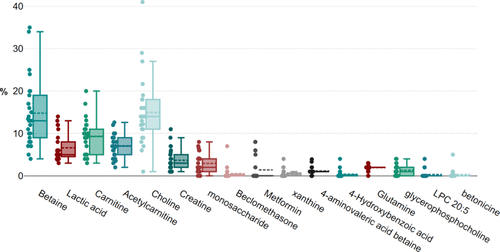

*Figure 1*. Box plot illustrating the percentages of the 16 key detected small molecules, each contributing over 3% in at least one of the exudates across all 25 sampled human cases. Each dotted line represents the percentage for an individual human exudate.

In [ ]:
# Loading libraries
import cobra
import micom as m
import pandas as pd

# Loading models for pathogenic species
s_aureus = cobra.io.read_sbml_model(models_dictionary['s_aureus_usa300'])
p_aeruginosa_pao1 = cobra.io.read_sbml_model(models_dictionary['p_aeruginosa_pao1'])
b_fragilis = cobra.io.read_sbml_model(models_dictionary['b_fragilis_nctc_9343'])
# Constructing a community
pathogenTax = create_tax_dataset([s_aureus, p_aeruginosa_pao1, b_fragilis], [models_dictionary['s_aureus_usa300'], models_dictionary['p_aeruginosa_pao1'], models_dictionary['b_fragilis_nctc_9343']], abundance=[250,250,200])
complete_pathogen_community = m.Community(pathogenTax)

Output()

In [12]:
# Example DFU exudate medium dictionary for MICOM
# Units are assumed to be in mM (or converted uptake fluxes).
dfu_medium = {
    "EX_glc_D_m": 10.0,   # High glucose (e.g., 10 mM)
    "EX_o2_m": 0.2,        # Low oxygen (e.g., 0.2 mM)
    "EX_lac_L_m": 2.5,    # Moderate lactate (e.g., 2.5 mM)
    "EX_arg_L_m": 0.1,    # Low arginine (e.g., 0.1 mM)
    "EX_crn_m" : 3.5,       # Moderate carnitine
    "EX_glyb_m": 13.0,      # High betaine
    "EX_chol_m": 12.0,      # High choline
    # Optionally, add additional metabolites as needed:
    # "EX_nh4_e": 5.0,     # Example: moderate ammonium concentration
    # "EX_glc__D_e": 10.0,  # Maintain other nutrients at their typical DFU levels
}

In [13]:
final_culture_medium = minimal_dfu_medium(complete_pathogen_community, dfu_medium)

In [15]:
# Displaying the final culture medium
MEDIUM = pd.DataFrame(final_culture_medium)
MEDIUM
# Saving the medium to a CSV
#MEDIUM.to_csv('../env/dfu_medium.csv')

,0
EX_12dgr180_m,0.428026
EX_26dap_M_m,3.351355
EX_4abz_m,0.245237
EX_adocbl_m,45.464587
EX_alagln_m,33.333333
...,...
EX_amylopect900_m,0.235874
EX_amylose300_m,0.333333
EX_dsT_antigen_m,16.666667
EX_eltr_m3_m,0.015941


### Probiotic Cocultures

In [9]:
# Loading models for probiotic species
l_brevis = cobra.io.read_sbml_model(models_dictionary['l_brevis_atcc367'])
l_plantarum_jdm1 = cobra.io.read_sbml_model(models_dictionary['l_plantarum_jdm1'])
l_plantarum_wcfs1 = cobra.io.read_sbml_model(models_dictionary['l_plantarum_wcfs1'])

In [97]:
# Creating communities consisting of pairs of them
coculture_subsets, path_subset = sort_into_subsets([l_brevis, l_plantarum_jdm1, l_plantarum_wcfs1],
                                      [models_dictionary['l_brevis_atcc367'], models_dictionary['l_plantarum_jdm1'],
                                       models_dictionary['l_plantarum_wcfs1']], 2) # Setting the number of strains in each sample to 2 (Pairwise cocultures)
# Setting up taxonomies for each of the subsets
taxonomy_datasets = []
#db_datasets = []
for culture, path in zip(coculture_subsets, path_subset):
    tax = create_tax_dataset(culture, path, [100, 100], include_sample_id = False, samples=1, scatter=30)
    taxonomy_datasets.append(tax)
    #taxonomy_datasets.append(tax.drop(labels=['sample_id', 'abundance'], axis=1).iloc[:2])
    #db_datasets.append(tax.drop(['file'], axis=1))

In [99]:
# Constructing communities for each of the taxnomomic datasets
import numpy as np
import pandas as pd

probiotic_communities = np.empty(len(taxonomy_datasets), dtype=pd.DataFrame)
for ind, tax in enumerate(taxonomy_datasets):
    probiotic_communities[ind] = m.Community(tax, progress=False)

In [100]:
# Optimizing each of the communities generated
solutions = []
for comm in probiotic_communities:
    solutions.append(comm.optimize(fluxes=True))

Here it must be noted that, for a probiotic solution to be worthwhile, its community must have the maximal growth rate possible. Accordingly, from here on, I will be choosing the two communities with the highest growth *maximal* rates (i.e. when they are optimized) and later assessing them when in contact with pathogens. 

In [101]:
from micom.viz import plot_association, plot_exchanges_per_sample, plot_growth
growth = [m.workflows.GrowthResults.from_solution(solutions[i], probiotic_communities[i]) for i in range(len(solutions))]
for g in growth:
    plot_growth(g)

In [ ]:
print('L. brevis ATCC 367')
find_reactions(l_brevis, 'Pyruvate', True)
print('L. plantarum JDM1')
find_reactions(l_plantarum_jdm1, 'glucose')
print('L. plantarum WCFS1')
find_reactions(l_plantarum_wcfs1, 'glucose')

In [109]:
elasticities = []
knockout_analyses = []
interactions = []
mes = []
for ind, comm in enumerate(probiotic_communities):
    knockout_analyses.append(comm.knockout_taxa(progress=True, diag=False))
    # Converting the current solution to a GrowthResults
    gro = m.workflows.GrowthResults.from_solution(solutions[ind], comm)
    #mes = m.interaction.MES(gro, 0.0001)
    interactions.append(m.interaction.interactions(gro, taxa=comm.taxa, progress=False))

Output()

Output()

Output()

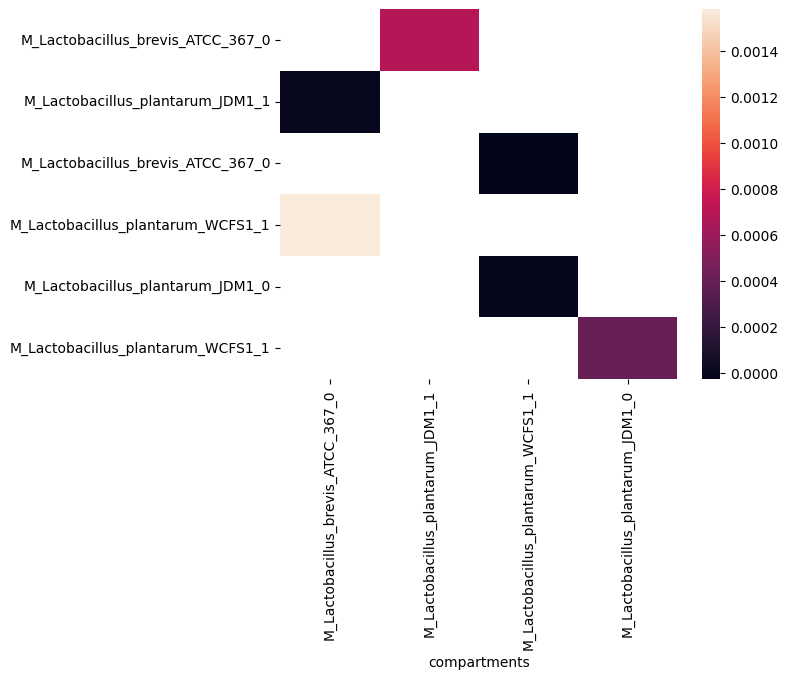

In [110]:
# Saving the results
import seaborn as sns
final_ko_results = pd.concat(knockout_analyses)
sns.heatmap(final_ko_results)
final_ko_results.to_csv('probiotic_coculture_taxa_ko.csv')

### Pathogenic Cocultures

In [10]:
# Loading models for probiotic species
s_aureus = cobra.io.read_sbml_model(models_dictionary['s_aureus_usa300'])
p_aeruginosa_pao1 = cobra.io.read_sbml_model(models_dictionary['p_aeruginosa_pao1'])
#p_aeruginosa_ncgm2_s1 = cobra.io.read_sbml_model(models_dictionary['p_aeruginosa_ncgm2_s1'])
b_fragilis = cobra.io.read_sbml_model(models_dictionary['b_fragilis_nctc_9343'])

In [11]:
# Creating communities consisting of pairs of them
coculture_subsets, path_subset = sort_into_subsets([s_aureus, p_aeruginosa_pao1, b_fragilis],
                                      [models_dictionary['s_aureus_usa300'], models_dictionary['p_aeruginosa_pao1'],
                                       models_dictionary['b_fragilis_nctc_9343']], 2)
# Setting up taxonomies for each of the subsets
taxonomy_datasets = []
for culture, path in zip(coculture_subsets, path_subset):
    taxonomy_datasets.append(create_tax_dataset(culture, path, [100, 100]))

Before updating the coculture media to resemble that of the DFU, the pathogen communities (which dictate how the medium should look like), will be run once while their community growth rates are compared and averaged. This will help in formulating the medium. This part of the process may be moved to the `coculture_benchmark` notebook in order to improve readability and intrepability of the workflow.

In [12]:
# Loading the DFU medium
dfu_medium = load_medium(replace_suffix=False)

In [13]:
# Constructing default communities for each of the taxnomomic datasets
import numpy as np
import pandas as pd

pathogen_communities = np.empty(len(taxonomy_datasets), dtype=pd.DataFrame)
for ind, tax in enumerate(taxonomy_datasets):
    pathogen_communities[ind] = m.Community(tax)

Output()

Output()

Output()

In [14]:
# Optimizing each of the communities generated
solutions = []
for comm in pathogen_communities:
    comm.medium = dfu_medium
    solutions.append(comm.optimize(fluxes=True))

In [15]:
# Displaying the list of growth rates
print([r.growth_rate for r in solutions])
solutions[2]

[9.868669773508518, 23.035957825602594, 12.489656667721418]


,abundance,growth_rate,reactions,metabolites
compartments,,,,
M_Bacteroides_fragilis_NCTC_9343_1,0.5,-4.806315e-12,2337,1987
M_Pseudomonas_aeruginosa_PAO1_0,0.5,2.497931e+01,2157,2022
medium,NaN,NaN,585,585


In [18]:
from micom.viz import plot_association, plot_exchanges_per_sample, plot_growth
growth = [m.workflows.GrowthResults.from_solution(solutions[i], pathogen_communities[i]) for i in range(len(solutions))]
for g in growth:
    plot_growth(g, 'growth_rates_all_pathogens.html')

According to the results, the communities with *B. fragilis* show more growth compared to those without it. This could be due to the fact that *B. fragilis* does not compete for the limited oxygen available at wound site with the aerobic *P.aeruginosa* and *S. aureus*. By looking at the third coculture, one can see that the growth of *B. fragilis* is completely inhibited by *P.aeruginosa*. Rerunning a larger coculture of 3 pathogens was warranted to see how *B. fragilis* fits into the final model of the microbiome.

In [19]:
all_pathogens_tax = create_tax_dataset([p_aeruginosa_pao1, s_aureus, b_fragilis],
                                    [models_dictionary['p_aeruginosa_pao1'], models_dictionary['s_aureus_usa300'], models_dictionary['b_fragilis_nctc_9343']],
                                    [250, 250, 200])

In [20]:
all_pathogens = m.Community(all_pathogens_tax)

Output()

In [21]:
# Performing OptCom to see how the community grows with respect to its individuals and the entire community
# This method is commonly used to estimate growth in a more-or-less stable community, which is a good estimation
# of a DFU when assessed at a particular point in time (i.e. change is negligble and so the egoistic growth may be the same as community's growth)
#solution_pathogens = all_pathogens.optimize_all(True)
solution_pathogen_community = all_pathogens.optimize(pfba=True)

In [22]:
solution_pathogen_community

,abundance,growth_rate,reactions,metabolites
compartments,,,,
M_Bacteroides_fragilis_NCTC_9343_2,0.285714,43.744704,2337,1987
M_Pseudomonas_aeruginosa_PAO1_0,0.357143,44.214935,2157,2022
M_Staphylococcus_aureus_subsp_aureus_USA300_FPR3757_1,0.357143,44.415450,1514,1250
medium,NaN,NaN,615,615


In [23]:
from micom.viz import plot_association, plot_exchanges_per_sample, plot_growth
growth = [m.workflows.GrowthResults.from_solution(solutions[i], pathogen_communities[i]) for i in range(len(solutions))]
for g in growth:
    plot_growth(g, 'growth_rates_all_pathogens_together.html')

Thus, in spite of *B. fragilis* not capable of growing in coculture with *P. aeruginosa* only, it is capable growing when *S. aureus* is in the community.

### Mixed Cocultures

In [ ]:
mixed_cocultures = []

#### *P. aeruginosa* PAO1 with *L. brevis* ATCC 367

In [309]:
import micom as m
import cobra
import pandas as pd
import numpy as np

In [310]:
# Loading models
p_aeruginosa_pao1 = cobra.io.read_sbml_model(models_dictionary['p_aeruginosa_pao1'])
l_brevis = cobra.io.read_sbml_model(models_dictionary['l_brevis_atcc367'])

In [311]:
# Building a taxonomy file with equal and unequal (biased towards the pathogen) abundances
equal_tax = create_tax_dataset([p_aeruginosa_pao1, l_brevis], paths=[models_dictionary['p_aeruginosa_pao1'], models_dictionary['l_brevis_atcc367']], abundance=[100, 100])
unequal_tax = create_tax_dataset([p_aeruginosa_pao1, l_brevis], paths=[models_dictionary['p_aeruginosa_pao1'], models_dictionary['l_brevis_atcc367']], abundance=[150, 50])

In [312]:
# Building communities
co_l_brevis_p_aeruginosa = []
co_l_brevis_p_aeruginosa.append(m.Community(equal_tax, name="Mixed Coculture of L. brevis and P. aeruginosa (Equal)"))
co_l_brevis_p_aeruginosa.append(m.Community(unequal_tax, name="Mixed Coculture of L. brevis and P. aeruginosa (Unequal)"))

Output()

Output()

In [ ]:
# Building communities with multiple samples
random_tax = create_tax_dataset([p_aeruginosa_pao1, l_brevis], paths=[models_dictionary['p_aeruginosa_pao1'], models_dictionary['l_brevis_atcc367']], abundance=[100, 100], include_sample_id=True, samples=4)
co_l_brevis_p_aeruginosa.append(m.Community(random_tax))


,id,genus,species,reactions,metabolites,file,sample_id,abundance
0,M_Pseudomonas_aeruginosa_PAO1_0,Pseudomonas,Pseudomonas aeruginosa PAO1,2155,2022,../model_data/Pseudomonas_aeruginosa_PAO1.xml,sample_1,100
1,M_Lactobacillus_brevis_ATCC_367_1,Lactobacillus,Lactobacillus brevis ATCC 367,1865,1597,../model_data/Lactobacillus_brevis_ATCC_367.xml,sample_1,100
2,M_Pseudomonas_aeruginosa_PAO1_0,Pseudomonas,Pseudomonas aeruginosa PAO1,2155,2022,../model_data/Pseudomonas_aeruginosa_PAO1.xml,sample_2,100
3,M_Lactobacillus_brevis_ATCC_367_1,Lactobacillus,Lactobacillus brevis ATCC 367,1865,1597,../model_data/Lactobacillus_brevis_ATCC_367.xml,sample_2,100
4,M_Pseudomonas_aeruginosa_PAO1_0,Pseudomonas,Pseudomonas aeruginosa PAO1,2155,2022,../model_data/Pseudomonas_aeruginosa_PAO1.xml,sample_3,100
5,M_Lactobacillus_brevis_ATCC_367_1,Lactobacillus,Lactobacillus brevis ATCC 367,1865,1597,../model_data/Lactobacillus_brevis_ATCC_367.xml,sample_3,100
6,M_Pseudomonas_aeruginosa_PAO1_0,Pseudomonas,Pseudomonas aeruginosa PAO1,2155,2022,../model_data/Pseudomonas_aeruginosa_PAO1.xml,sample_4,100
7,M_Lactobacillus_brevis_ATCC_367_1,Lactobacillus,Lactobacillus brevis ATCC 367,1865,1597,../model_data/Lactobacillus_brevis_ATCC_367.xml,sample_4,100


In [330]:
# Updating media
for comm in co_l_brevis_p_aeruginosa:
    comm.medium = final_culture_medium

In [331]:
# Optimizing communities
solutions = []
solutions.append(co_l_brevis_p_aeruginosa[0].optimize(fluxes = True, pfba = True)) # Equal
solutions.append(co_l_brevis_p_aeruginosa[1].optimize(fluxes = True, pfba = True)) # Unequal

In [335]:
# Displaying results
solutions[0]

,abundance,growth_rate,reactions,metabolites
compartments,,,,
M_Lactobacillus_brevis_ATCC_367_1,0.5,3.638740,1865,1597
M_Pseudomonas_aeruginosa_PAO1_0,0.5,13.687034,2155,2022
medium,NaN,NaN,537,537


In [ ]:
from micom.viz import plot_growth
pl = plot_growth(m.workflows.GrowthResults.from_solution(solutions[0], co_l_brevis_p_aeruginosa[0]), "Mixed_Cocultures_l_brevis_p_aeruginosa.html")

### All of the models together

In [24]:
microbiota_tax = create_tax_dataset([l_brevis, l_plantarum_jdm1, l_plantarum_wcfs1, p_aeruginosa_pao1, s_aureus, b_fragilis],
                                    [models_dictionary['l_brevis_atcc367'], models_dictionary['l_plantarum_jdm1'], models_dictionary['l_plantarum_wcfs1'], models_dictionary['p_aeruginosa_pao1'], models_dictionary['s_aureus_usa300'], models_dictionary['b_fragilis_nctc_9343']],
                                    [100, 100, 100, 250, 250, 200])
microbiota = m.Community(microbiota_tax)

Output()

In [26]:
# Plotting microbiome growth
microbiota_solution = microbiota.optimize(fluxes=True, pfba=True)
from micom.viz import plot_growth
growth = m.workflows.GrowthResults.from_solution(microbiota_solution, microbiota)
plot_growth(g, 'growth_rates_microbiota.html')

In [ ]:
knockout_analyses = []
for ind, comm in enumerate([microbiota]):
    knockout_analyses.append(comm.knockout_taxa(progress=True, diag=False))

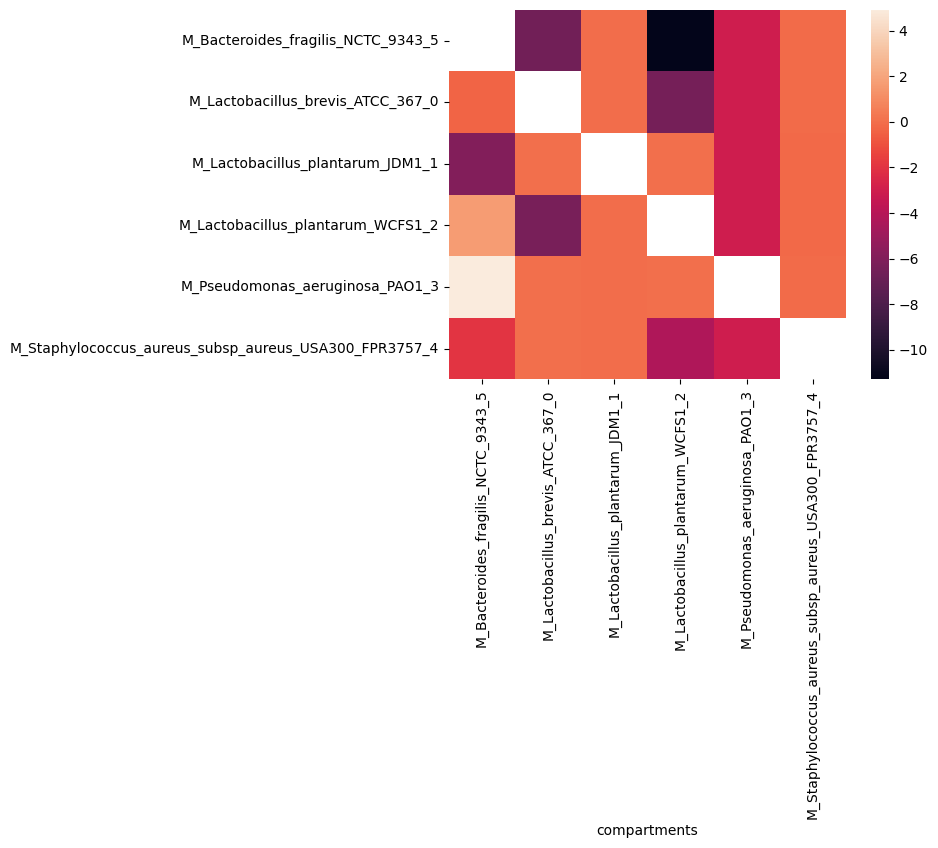

In [28]:
# Saving the results
import seaborn as sns
final_ko_results = knockout_analyses[0]
sns.heatmap(final_ko_results)
final_ko_results.to_csv('microbiota_taxa_ko.csv')

### SHELVED

In [145]:
b_fragilis = cobra.io.read_sbml_model(models_dictionary['b_fragilis_nctc_9343'])
# Applying the oxygen constraint onto the b_fragilis model
from optlang import Variable, Constraint, Objective
# Storing reactions for oxygen and biomass
o2_rxn = b_fragilis.reactions.get_by_id('EX_o2(e)')
biomass_rxn = b_fragilis.reactions.get_by_id('EX_biomass(e)')
# Declaring the alpha parameter to adjust the sensitivity
_alpha_param = 0.1
# Setting the model objective to biomass + alpha * v_o2, which will penalize oxygen uptake
b_fragilis.objective = biomass_rxn
b_fragilis.objective.set_linear_coefficients({o2_rxn.forward_variable: _alpha_param})

In [ ]:
b_fragilis = cobra.io.read_sbml_model(models_dictionary['b_fragilis_nctc_9343'])
# Applying the oxygen constraint onto the b_fragilis model
from optlang import Variable, Constraint
# Storing reactions for oxygen and biomass
o2_rxn = b_fragilis.reactions.get_by_id('EX_o2(e)')
biomass_rxn = b_fragilis.reactions.get_by_id('EX_biomass(e)')
# Storing the maximum allowed flux for biomass growth
biomass_max = b_fragilis.reactions.get_by_id('EX_biomass(e)').upper_bound
# Declaring the alpha parameter to adjust the sensitivity
_alpha_param = 0.1
# Declaring the constraint expression
expression = biomass_rxn.flux_expression + _alpha_param*o2_rxn.flux_expression
oxygen_cons = Constraint(expression, lb=-1e-6, ub=biomass_max)
b_fragilis.solver.add(oxygen_cons)